# Introduction to empirical market microstructure in Python

Prepared by [Vincent Grégoire](http://www.vincentgregoire.com), Department of Finance, The University of Melbourne. 

This is a sample code to illustrate how you can merge and analyze intraday financial data.

This code loads and analyzes intraday trades and quotes for all ASX20 stocks for the first two weeks of
March 2017 using
data from from [Thomson Reuters Tick History](https://tickhistory.thomsonreuters.com/), provided by [SIRCA](https://www.sirca.org.au/). 

This notebook was created as supplemental material to a Python for financial research bootcamp for finance honours and PhD students at the University of Melbourne in March of 2017.

Last update: March 30, 2017.

**Contact**: <vincent.gregoire@unimelb.edu.au>

Latest version: <http://www.vincentgregoire.com/python-bootcamp/>



**Outline**:

- Load trades and quotes
- Parsing timestamps (and convert from UTC)
- Cleaning, forward filling quotes
- Realized spread (merging asof)
- Time-weigthed depth
- Plot something
- Summarize data at the stock/day level



In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
import matplotlib.pyplot as plt

The data requested from TRTH is in a file named "ASX20_HalfMarch2017.csv.gz". First, let's get a sense of the data.

In [2]:
pd.read_csv('data/ASX20_HalfMarch2017.csv.gz', nrows=100)

,#RIC,Current RIC,Date[L],Time[L],Type,Price,Volume,Bid Price,Bid Size,Ask Price,Ask Size,Qualifiers,Exch Time,Trd/Qte Date,Quote Time
0,AMP.AX,NaN,03/01/2017,06:10:21.249,Quote,NaN,NaN,4.86,1000.0,NaN,NaN,NaN,NaN,NaN,19:10:21.000
1,AMP.AX,NaN,03/01/2017,06:10:21.249,Quote,NaN,NaN,4.86,2000.0,NaN,NaN,NaN,NaN,NaN,19:10:21.000
2,AMP.AX,NaN,03/01/2017,06:10:21.249,Quote,NaN,NaN,NaN,NaN,4.89,2000.0,NaN,NaN,NaN,19:10:21.000
3,AMP.AX,NaN,03/01/2017,07:00:03.289,Quote,NaN,NaN,4.87,175.0,NaN,NaN,NaN,NaN,NaN,20:00:03.000
4,AMP.AX,NaN,03/01/2017,07:01:28.368,Quote,NaN,NaN,4.88,1000.0,NaN,NaN,NaN,NaN,NaN,20:01:28.000
5,AMP.AX,NaN,03/01/2017,07:03:18.538,Quote,NaN,NaN,NaN,NaN,4.91,1050.0,NaN,NaN,NaN,20:03:18.000
6,AMP.AX,NaN,03/01/2017,07:10:12.544,Quote,NaN,NaN,NaN,NaN,4.64,1759.0,NaN,NaN,NaN,20:10:12.000
7,AMP.AX,NaN,03/01/2017,08:30:05.654,Quote,NaN,NaN,5.27,195.0,NaN,NaN,NaN,NaN,NaN,21:30:05.000
8,AMP.AX,NaN,03/01/2017,08:30:10.604,Quote,NaN,NaN,5.27,173.0,NaN,NaN,NaN,NaN,NaN,21:30:10.000
9,AMP.AX,NaN,03/01/2017,08:48:48.448,Quote,NaN,NaN,5.27,225.0,NaN,NaN,NaN,NaN,NaN,21:48:48.000


In this case we won't use the TRTH timestamps (we'll use exchange timestamps). It will also be more practictal to split trades and quotes in different datasets.

In [3]:
cols = ['#RIC', 'Date[L]', 'Type', 'Price', 'Volume', 'Bid Price', 'Bid Size',
        'Ask Price', 'Ask Size', 'Qualifiers', 'Exch Time', 'Quote Time']
df = pd.read_csv('data/ASX20_HalfMarch2017.csv.gz', usecols=cols)

In [4]:
df_quotes = df.loc[df.Type=='Quote', ['#RIC', 'Date[L]','Bid Price', 'Bid Size',
                                      'Ask Price', 'Ask Size', 'Quote Time']].copy()
df_quotes.head()

,#RIC,Date[L],Bid Price,Bid Size,Ask Price,Ask Size,Quote Time
0,AMP.AX,03/01/2017,4.86,1000.0,NaN,NaN,19:10:21.000
1,AMP.AX,03/01/2017,4.86,2000.0,NaN,NaN,19:10:21.000
2,AMP.AX,03/01/2017,NaN,NaN,4.89,2000.0,19:10:21.000
3,AMP.AX,03/01/2017,4.87,175.0,NaN,NaN,20:00:03.000
4,AMP.AX,03/01/2017,4.88,1000.0,NaN,NaN,20:01:28.000


In [5]:
df_trades = df.loc[df.Type=='Trade', ['#RIC', 'Date[L]', 'Price', 'Volume', 'Qualifiers', 'Exch Time']].copy()
df_trades.head()

,#RIC,Date[L],Price,Volume,Qualifiers,Exch Time
63,AMP.AX,03/01/2017,4.86,1985.0,[ACT_FLAG1];MO [GV4_TEXT];Open|High|Low[USER],23:00:11.000
64,AMP.AX,03/01/2017,4.86,753.0,[ACT_FLAG1];MO [GV4_TEXT],23:00:11.000
65,AMP.AX,03/01/2017,4.86,424.0,[ACT_FLAG1];MO [GV4_TEXT],23:00:11.000
66,AMP.AX,03/01/2017,4.86,912.0,[ACT_FLAG1];MO [GV4_TEXT],23:00:11.000
67,AMP.AX,03/01/2017,4.86,618.0,[ACT_FLAG1];MO [GV4_TEXT],23:00:11.000


In [6]:
len(df_quotes)

5818262

In [7]:
len(df_trades)

2501299

To parse dates and timestamps, we'll use the same trick we used for CRSP data. We parse date and time separately since there is much more redundancy in dates.

In [8]:
def parse_simple_date(d):
    return datetime.strptime(d, '%m/%d/%Y')

def parse_simple_time(t):
    # The data is up to the second precision.
    return timedelta(hours=int(t[0:2]), minutes=int(t[3:5]),
                     seconds=int(t[6:8]))

def fast_date_parse(df, col, date_parser=parse_simple_date):
    dt = pd.DataFrame(df[col].unique())
    dt.columns = [col + '_tmp']
    dt[col] = dt[col + '_tmp'].apply(date_parser)
    date_dict = dt.set_index(col + '_tmp').to_dict()
    df[col] = df[col].map(date_dict[col])
    return df

In [9]:
# To join dates and times, we need to account for time zone. Dates are local dates (Sydney),
# but times are in UTC.
df_trades = fast_date_parse(df_trades, 'Exch Time', parse_simple_time)
df_trades = fast_date_parse(df_trades, 'Date[L]')
df_trades['Timestamp'] = (df_trades['Date[L]'].dt.tz_localize('UTC').dt.tz_convert('Australia/Sydney') +
                          df_trades['Exch Time'])
sel = (df_trades.Timestamp.dt.date != df_trades['Date[L]'].dt.date)
df_trades.loc[sel, 'Timestamp'] = df_trades.loc[sel, 'Timestamp'] - timedelta(days=1)
df_trades.head()

,#RIC,Date[L],Price,Volume,Qualifiers,Exch Time,Timestamp
63,AMP.AX,2017-03-01,4.86,1985.0,[ACT_FLAG1];MO [GV4_TEXT];Open|High|Low[USER],23:00:11,2017-03-01 10:00:11+11:00
64,AMP.AX,2017-03-01,4.86,753.0,[ACT_FLAG1];MO [GV4_TEXT],23:00:11,2017-03-01 10:00:11+11:00
65,AMP.AX,2017-03-01,4.86,424.0,[ACT_FLAG1];MO [GV4_TEXT],23:00:11,2017-03-01 10:00:11+11:00
66,AMP.AX,2017-03-01,4.86,912.0,[ACT_FLAG1];MO [GV4_TEXT],23:00:11,2017-03-01 10:00:11+11:00
67,AMP.AX,2017-03-01,4.86,618.0,[ACT_FLAG1];MO [GV4_TEXT],23:00:11,2017-03-01 10:00:11+11:00


In [10]:
df_quotes = fast_date_parse(df_quotes, 'Quote Time', parse_simple_time)
df_quotes = fast_date_parse(df_quotes, 'Date[L]')
df_quotes['Timestamp'] = (df_quotes['Date[L]'].dt.tz_localize('UTC').dt.tz_convert('Australia/Sydney') +
                          df_quotes['Quote Time'])
sel = (df_quotes.Timestamp.dt.date != df_quotes['Date[L]'].dt.date)
df_quotes.loc[sel, 'Timestamp'] = df_quotes.loc[sel, 'Timestamp'] - timedelta(days=1)
df_quotes.head()

,#RIC,Date[L],Bid Price,Bid Size,Ask Price,Ask Size,Quote Time,Timestamp
0,AMP.AX,2017-03-01,4.86,1000.0,NaN,NaN,19:10:21,2017-03-01 06:10:21+11:00
1,AMP.AX,2017-03-01,4.86,2000.0,NaN,NaN,19:10:21,2017-03-01 06:10:21+11:00
2,AMP.AX,2017-03-01,NaN,NaN,4.89,2000.0,19:10:21,2017-03-01 06:10:21+11:00
3,AMP.AX,2017-03-01,4.87,175.0,NaN,NaN,20:00:03,2017-03-01 07:00:03+11:00
4,AMP.AX,2017-03-01,4.88,1000.0,NaN,NaN,20:01:28,2017-03-01 07:01:28+11:00


As we can see, quotes get updated only one side at a time, so we need to fill forward the quotes.

We will first do the processing on one day only. It will be easier to see, and then we can write a function
with our code to loop over every day in the sample. This is usually a good approach, when the processing is split into logical elements (ie. stock or day) it is easier to write and to run in parallel.

In [11]:
quotes = df_quotes[df_quotes['Date[L]'] == datetime(2017, 3, 1)].copy()
trades = df_trades[df_trades['Date[L]'] == datetime(2017, 3, 1)].copy()

In [12]:
quotes_cols = ['Bid Price', 'Bid Size', 'Ask Price', 'Ask Size']
quotes[quotes_cols] = quotes.groupby(['#RIC'])[quotes_cols].fillna(method='ffill')
# Missing values implie no depth
quotes[['Bid Size', 'Ask Size']] = quotes[['Bid Size', 'Ask Size']].fillna(0.0)
quotes.head()

,#RIC,Date[L],Bid Price,Bid Size,Ask Price,Ask Size,Quote Time,Timestamp
0,AMP.AX,2017-03-01,4.86,1000.0,NaN,0.0,19:10:21,2017-03-01 06:10:21+11:00
1,AMP.AX,2017-03-01,4.86,2000.0,NaN,0.0,19:10:21,2017-03-01 06:10:21+11:00
2,AMP.AX,2017-03-01,4.86,2000.0,4.89,2000.0,19:10:21,2017-03-01 06:10:21+11:00
3,AMP.AX,2017-03-01,4.87,175.0,4.89,2000.0,20:00:03,2017-03-01 07:00:03+11:00
4,AMP.AX,2017-03-01,4.88,1000.0,4.89,2000.0,20:01:28,2017-03-01 07:01:28+11:00


Let's create a few measures.

In [13]:
quotes['MidQuote'] = (quotes['Bid Price'] + quotes['Ask Price'])/2.0
quotes['DepthOnTop'] = (quotes['Bid Size'] + quotes['Ask Size'])/2.0
quotes['Spread'] = quotes['Ask Price'] - quotes['Bid Price']
quotes['RelSpread'] = quotes['Spread']/quotes['MidQuote']

In [14]:
trades['Value'] = trades['Price'] * trades['Volume']

We want to focus on continuous trading.

We can look at trading hours on [ASX's website](http://www.asx.com.au/about/trading-hours.htm).

By 10:10am all stocks should be open, and they all stop at 4pm for an auction about 10 minutes later.

In [15]:
# We will focus on continuous trading. 
start_time = time(hour=10, minute=10)
end_time = time(hour=16, minute=0)

In [16]:
sel = ((trades.Timestamp.dt.time > start_time) &
       (trades.Timestamp.dt.time < end_time))

trades_open = trades[sel].copy()

In [17]:
sel = ((trades.Timestamp.dt.time > start_time) &
       (trades.Timestamp.dt.time < end_time))

trades_open = trades[sel].copy()

In [18]:
trades_open = trades_open.sort_values(['Timestamp', '#RIC'])
quotes = quotes.sort_values(['Timestamp', '#RIC'])

## Spreads

Two common measures for the cost of trading are the effective spread and the realized spread.

The definition for each of them is the following:

### Effective spread

Buy market order: $2\times p_t - m_t$

Sell market order: $2\times m_t - p_t$

where $p_t$ is the price for the transaction at time $t$, and $m_t$ is the mid quote at time $t-\varepsilon$ (just before the trade).


### Realized spread

Buy market order: $2\times p_t - m_{t+\Delta}$

Sell market order: $2\times m_{t+\Delta} - p_t$

where $p_t$ is the price for the transaction at time $t$, and $m_{t+\Delta}$ is the mid quote at time ${t+\Delta}$. A common value for $\Delta$ is 5 minutes, so we'll use that.




First, we need to merge trades and quotes at the right time.

In [19]:
trades_open['TS_5min'] = trades_open['Timestamp'] + timedelta(minutes=5)

In [20]:
taq_merged = pd.merge_asof(trades_open,
                           quotes[['#RIC', 'Timestamp', 'Bid Price', 'Ask Price', 'MidQuote']],
                           on='Timestamp', by='#RIC', allow_exact_matches=False)

taq_merged = pd.merge_asof(taq_merged,
                           quotes[['#RIC', 'Timestamp', 'Bid Price', 'Ask Price', 'MidQuote']],
                           left_on='TS_5min', right_on='Timestamp',
                           by='#RIC', suffixes=('', '_5min'),
                           allow_exact_matches=False)

In [21]:
taq_merged.head()

,#RIC,Date[L],Price,Volume,Qualifiers,Exch Time,Timestamp,Value,TS_5min,Bid Price,Ask Price,MidQuote,Timestamp_5min,Bid Price_5min,Ask Price_5min,MidQuote_5min
0,AMP.AX,2017-03-01,4.87,1235.0,S[ACT_FLAG1]; [GV4_TEXT],23:10:01,2017-03-01 10:10:01+11:00,6014.45,2017-03-01 10:15:01+11:00,4.87,4.88,4.875,2017-03-01 10:15:00+11:00,4.87,4.88,4.875
1,AMP.AX,2017-03-01,4.87,128.0,S[ACT_FLAG1]; [GV4_TEXT],23:10:01,2017-03-01 10:10:01+11:00,623.36,2017-03-01 10:15:01+11:00,4.87,4.88,4.875,2017-03-01 10:15:00+11:00,4.87,4.88,4.875
2,AMP.AX,2017-03-01,4.87,3.0,S[ACT_FLAG1]; [GV4_TEXT],23:10:01,2017-03-01 10:10:01+11:00,14.61,2017-03-01 10:15:01+11:00,4.87,4.88,4.875,2017-03-01 10:15:00+11:00,4.87,4.88,4.875
3,CBA.AX,2017-03-01,81.83,15.0,S[ACT_FLAG1]; [GV4_TEXT],23:10:01,2017-03-01 10:10:01+11:00,1227.45,2017-03-01 10:15:01+11:00,81.83,81.88,81.855,2017-03-01 10:15:00+11:00,82.07,82.14,82.105
4,CSL.AX,2017-03-01,117.99,29.0,S[ACT_FLAG1]; [GV4_TEXT],23:10:01,2017-03-01 10:10:01+11:00,3421.71,2017-03-01 10:15:01+11:00,117.99,118.12,118.055,2017-03-01 10:15:00+11:00,117.76,117.86,117.810


We next need to "sign" the trades, figure out if it's a buy or a sell.

In [22]:
taq_merged['Sign'] = ''
taq_merged.loc[taq_merged.Price == taq_merged['Bid Price'], 'Sign'] = 'S'
taq_merged.loc[taq_merged.Price == taq_merged['Ask Price'], 'Sign'] = 'B'
taq_merged.loc[taq_merged.Price == taq_merged['MidQuote'], 'Sign'] = 'C' # Cross

In [23]:
taq_merged.head()

,#RIC,Date[L],Price,Volume,Qualifiers,Exch Time,Timestamp,Value,TS_5min,Bid Price,Ask Price,MidQuote,Timestamp_5min,Bid Price_5min,Ask Price_5min,MidQuote_5min,Sign
0,AMP.AX,2017-03-01,4.87,1235.0,S[ACT_FLAG1]; [GV4_TEXT],23:10:01,2017-03-01 10:10:01+11:00,6014.45,2017-03-01 10:15:01+11:00,4.87,4.88,4.875,2017-03-01 10:15:00+11:00,4.87,4.88,4.875,S
1,AMP.AX,2017-03-01,4.87,128.0,S[ACT_FLAG1]; [GV4_TEXT],23:10:01,2017-03-01 10:10:01+11:00,623.36,2017-03-01 10:15:01+11:00,4.87,4.88,4.875,2017-03-01 10:15:00+11:00,4.87,4.88,4.875,S
2,AMP.AX,2017-03-01,4.87,3.0,S[ACT_FLAG1]; [GV4_TEXT],23:10:01,2017-03-01 10:10:01+11:00,14.61,2017-03-01 10:15:01+11:00,4.87,4.88,4.875,2017-03-01 10:15:00+11:00,4.87,4.88,4.875,S
3,CBA.AX,2017-03-01,81.83,15.0,S[ACT_FLAG1]; [GV4_TEXT],23:10:01,2017-03-01 10:10:01+11:00,1227.45,2017-03-01 10:15:01+11:00,81.83,81.88,81.855,2017-03-01 10:15:00+11:00,82.07,82.14,82.105,S
4,CSL.AX,2017-03-01,117.99,29.0,S[ACT_FLAG1]; [GV4_TEXT],23:10:01,2017-03-01 10:10:01+11:00,3421.71,2017-03-01 10:15:01+11:00,117.99,118.12,118.055,2017-03-01 10:15:00+11:00,117.76,117.86,117.810,S


### Effective Spread

Buy market order: $2\times p_t - m_t$

Sell market order: $2\times m_t - p_t$

where $p_t$ is the price for the transaction at time $t$, and $m_t$ is the mid quote at time $t-\varepsilon$ (just before the trade).

In [24]:
# Create the variable for every obs
taq_merged['Effective Spread'] = np.nan
b_sel = taq_merged.Sign == 'B'
taq_merged.loc[b_sel, 'Effective Spread'] = 2*(taq_merged.loc[b_sel, 'Price'] -
                                               taq_merged.loc[b_sel, 'MidQuote'])
s_sel = taq_merged.Sign == 'S'
taq_merged.loc[s_sel, 'Effective Spread'] = 2*(taq_merged.loc[s_sel, 'MidQuote'] -
                                               taq_merged.loc[s_sel, 'Price'])

### Realized spread

Buy market order: $2\times p_t - m_{t+\Delta}$

Sell market order: $2\times m_{t+\Delta} - p_t$

where $p_t$ is the price for the transaction at time $t$, and $m_{t+\Delta}$ is the mid quote at time ${t+\Delta}$. We use $\Delta=$5 minutes.

In [25]:
# Create the variable for every obs
taq_merged['Realized Spread'] = np.nan
b_sel = taq_merged.Sign == 'B'
taq_merged.loc[b_sel, 'Realized Spread'] = 2*(taq_merged.loc[b_sel, 'Price'] -
                                              taq_merged.loc[b_sel, 'MidQuote_5min'])
s_sel = taq_merged.Sign == 'S'
taq_merged.loc[s_sel, 'Realized Spread'] = 2*(taq_merged.loc[s_sel, 'MidQuote_5min'] -
                                              taq_merged.loc[s_sel, 'Price'])

**Note**: here we might choose to do something special for trades in the last 5 minutes, such as recomputing realized spread using the closing auction price instead of the midquote. We won't do it, meaning we're using the prevailing mid quote at market close.

### Price impact

The realized spread is a measure of price impact, i.e. it measures how trades move prices. If prices move in the direction of the trade, realized spread becomes smaller and possibly negative. We might expect that price impact is related to trade size. To make everything comparable, we need to make the measures "relative" (i.e. in %) to something, either price or mid quote. We use the prevailing mid quote at trade time.

In [26]:
taq_merged['RelEffective Spread'] = taq_merged['Effective Spread'] / taq_merged['MidQuote']
taq_merged['RelRealized Spread'] = taq_merged['Realized Spread'] / taq_merged['MidQuote']

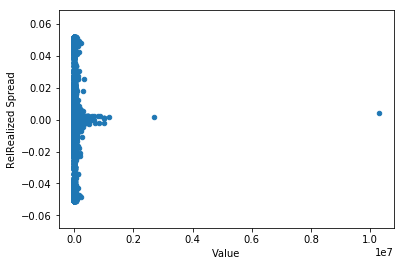

In [27]:
taq_merged.plot.scatter(x='Value', y='RelRealized Spread');

Ok, so we have a few outliers, so it's hard to see what is going on. One way around this issue is to group trades in value deciles.

In [28]:
taq_merged['Value_q10'] = pd.qcut(taq_merged['Value'], q=10, labels=False)

In [29]:
val_q10_mean = taq_merged.groupby('Value_q10')[['RelEffective Spread', 'RelRealized Spread', 
                                                'Effective Spread', 'Realized Spread']].mean()

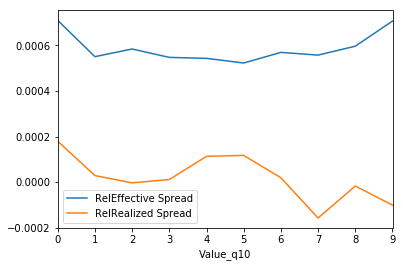

In [30]:
val_q10_mean[['RelEffective Spread', 'RelRealized Spread']].plot()

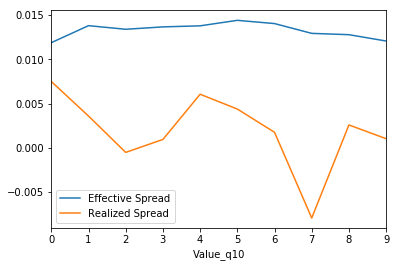

In [31]:
val_q10_mean[['Effective Spread', 'Realized Spread']].plot()

To get the average value for each stock/day, we can groupby.

In [32]:
spd_mean = taq_merged.groupby(['#RIC', 'Date[L]'])[['RelEffective Spread', 'RelRealized Spread', 
                               'Effective Spread', 'Realized Spread']].mean()
spd_mean

,,RelEffective Spread,RelRealized Spread,Effective Spread,Realized Spread
#RIC,Date[L],,,,
AMP.AX,2017-03-01,0.002044,-0.001045,0.010013,-0.005155
ANZ.AX,2017-03-01,0.000346,-0.000050,0.010710,-0.001564
BHP.AX,2017-03-01,0.000450,-0.000129,0.011135,-0.003179
BXB.AX,2017-03-01,0.001088,0.000254,0.010074,0.002352
CBA.AX,2017-03-01,0.000203,0.000145,0.016750,0.011985
CSL.AX,2017-03-01,0.000196,0.000057,0.023110,0.006686
IAG.AX,2017-03-01,0.001684,-0.000061,0.010101,-0.000369
MQG.AX,2017-03-01,0.000248,-0.000365,0.021457,-0.031516
NAB.AX,2017-03-01,0.000340,0.000127,0.010885,0.004062


In [33]:
# To get trade value-weighted average instead, it's not much harder.
cols = ['RelEffective Spread', 'RelRealized Spread',
        'Effective Spread', 'Realized Spread']
for c in cols:
    taq_merged[c + '_VW'] = taq_merged[c] * taq_merged['Value']

for c in cols:
    spd_mean[c + '_VW'] = (taq_merged.groupby(['#RIC', 'Date[L]'])[c + '_VW'].sum() /
                          taq_merged.groupby(['#RIC', 'Date[L]'])['Value'].sum())
spd_mean

,,RelEffective Spread,RelRealized Spread,Effective Spread,Realized Spread,RelEffective Spread_VW,RelRealized Spread_VW,Effective Spread_VW,Realized Spread_VW
#RIC,Date[L],,,,,,,,
AMP.AX,2017-03-01,0.002044,-0.001045,0.010013,-0.005155,0.001381,-0.000234,0.006765,-0.001150
ANZ.AX,2017-03-01,0.000346,-0.000050,0.010710,-0.001564,0.000231,-0.000151,0.007151,-0.004673
BHP.AX,2017-03-01,0.000450,-0.000129,0.011135,-0.003179,0.000333,-0.000327,0.008242,-0.008096
BXB.AX,2017-03-01,0.001088,0.000254,0.010074,0.002352,0.000795,0.000047,0.007359,0.000437
CBA.AX,2017-03-01,0.000203,0.000145,0.016750,0.011985,0.000119,0.000088,0.009783,0.007288
CSL.AX,2017-03-01,0.000196,0.000057,0.023110,0.006686,0.000116,0.000307,0.013725,0.036109
IAG.AX,2017-03-01,0.001684,-0.000061,0.010101,-0.000369,0.001457,-0.000154,0.008741,-0.000929
MQG.AX,2017-03-01,0.000248,-0.000365,0.021457,-0.031516,0.000152,-0.000367,0.013151,-0.031732
NAB.AX,2017-03-01,0.000340,0.000127,0.010885,0.004062,0.000232,-0.000049,0.007415,-0.001555


## Time-weighted measures

Another couple of interesting measures are the time-weighted spread and depth, which give an idea of the liquidity available. Since these are time-weighted, we take the average value, weighted by the duration of the spread or available depth.

In [34]:
# First, we need to compute the time interval. We cannot use diff() since we want the difference
# between the next timestmap (when a new quote/depth is set) and the current timestamp.
quotes['time_d'] = (quotes.groupby('#RIC')['Quote Time'].shift(-1) - quotes['Quote Time']).dt.total_seconds()

In [35]:
# Next, we do as before, using 'time_d' instead of Value for our weights.
cols = ['Spread', 'RelSpread', 'DepthOnTop']
for c in cols:
    quotes[c + '_TW'] = quotes[c] * quotes['time_d']

tw_mean = quotes.groupby(['#RIC', 'Date[L]'])[[c + '_TW' for c in cols]].sum()
    
for c in cols:
    tw_mean[c + '_TW'] = (tw_mean[c + '_TW'] /
                          quotes.groupby(['#RIC', 'Date[L]'])['time_d'].sum())
tw_mean

,,Spread_TW,RelSpread_TW,DepthOnTop_TW
#RIC,Date[L],,,
AMP.AX,2017-03-01,0.152458,0.031355,3.304217e+04
ANZ.AX,2017-03-01,0.693095,0.022598,2.342880e+04
BHP.AX,2017-03-01,0.670110,0.027070,-9.483283e+02
BXB.AX,2017-03-01,0.214808,0.022807,6.224641e+03
CBA.AX,2017-03-01,2.357897,0.028510,3.567609e+02
CSL.AX,2017-03-01,2.904086,0.024721,-5.302755e+02
IAG.AX,2017-03-01,0.190692,0.031914,-9.753459e+03
MQG.AX,2017-03-01,2.201808,0.025092,-2.889100e+02
NAB.AX,2017-03-01,1.030821,0.032600,6.616314e+02


In [36]:
# Now we can merge our two datasets

merged = pd.merge(spd_mean, tw_mean, left_index=True, right_index=True)
merged

,,RelEffective Spread,RelRealized Spread,Effective Spread,Realized Spread,RelEffective Spread_VW,RelRealized Spread_VW,Effective Spread_VW,Realized Spread_VW,Spread_TW,RelSpread_TW,DepthOnTop_TW
#RIC,Date[L],,,,,,,,,,,
AMP.AX,2017-03-01,0.002044,-0.001045,0.010013,-0.005155,0.001381,-0.000234,0.006765,-0.001150,0.152458,0.031355,3.304217e+04
ANZ.AX,2017-03-01,0.000346,-0.000050,0.010710,-0.001564,0.000231,-0.000151,0.007151,-0.004673,0.693095,0.022598,2.342880e+04
BHP.AX,2017-03-01,0.000450,-0.000129,0.011135,-0.003179,0.000333,-0.000327,0.008242,-0.008096,0.670110,0.027070,-9.483283e+02
BXB.AX,2017-03-01,0.001088,0.000254,0.010074,0.002352,0.000795,0.000047,0.007359,0.000437,0.214808,0.022807,6.224641e+03
CBA.AX,2017-03-01,0.000203,0.000145,0.016750,0.011985,0.000119,0.000088,0.009783,0.007288,2.357897,0.028510,3.567609e+02
CSL.AX,2017-03-01,0.000196,0.000057,0.023110,0.006686,0.000116,0.000307,0.013725,0.036109,2.904086,0.024721,-5.302755e+02
IAG.AX,2017-03-01,0.001684,-0.000061,0.010101,-0.000369,0.001457,-0.000154,0.008741,-0.000929,0.190692,0.031914,-9.753459e+03
MQG.AX,2017-03-01,0.000248,-0.000365,0.021457,-0.031516,0.000152,-0.000367,0.013151,-0.031732,2.201808,0.025092,-2.889100e+02
NAB.AX,2017-03-01,0.000340,0.000127,0.010885,0.004062,0.000232,-0.000049,0.007415,-0.001555,1.030821,0.032600,6.616314e+02


# Exercise

Now that we have done all of this for one day, package as a function to loop over every day in the sample (without the plots) 
and then merge to get a complete stock/day panel, and export it to CSV.